Topic: Stroke Prediction

Reference
- Streamlit deployment : https://pycaret.gitbook.io/docs/learn-pycaret/official-blog/build-and-deploy-ml-app-with-pycaret-and-streamlit
- Mlflow with pycaret: https://www.restack.io/docs/mlflow-knowledge-mlflow-pycaret-integration
- How to Use MLFlow with Jupyter and Google Colab https://medium.com/@modernai/how-to-use-mlflow-in-your-jupyter-and-colab-notebooks-011d39c27739
- Dataprep EDA: https://towardsdatascience.com/easy-mlops-with-pycaret-mlflow-7fbcbf1e38c6

- Running Low on Time? Use PyCaret to Build your Machine Learning Model in Seconds https://www.analyticsvidhya.com/blog/2020/05/pycaret-machine-learning-model-seconds/

- Pycaret: https://pycaret.gitbook.io/docs/get-started/functions/others
- PyCaret + MLflow: https://towardsdatascience.com/easy-mlops-with-pycaret-mlflow-7fbcbf1e38c6
- Automated EDA https://towardsdatascience.com/comparing-five-most-popular-eda-tools-dccdef05aa4c, https://medium.com/@HeCanThink/discover-dataprep-make-exploratory-data-analysis-easier-in-python-%EF%B8%8F-254896034d70, https://arxiv.org/pdf/2104.00841
- https://www.kaggle.com/code/rhythmcam/titanic-pycaret-decision-tree (note: setup() parameters is very interesting like `use_pca`, `remove_outliers`, `normalize`, `transformation`,`remove_multicollinearity`, `combine_rare_levels`, )

In [ ]:
#!pip install -q pycaret
#!pip install -q graphviz
#!pip install -q dataprep
#!pip install -q mlflow==2.7.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.27.0 requires sqlalchemy<3.0dev,>=1.4, but you have sqlalchemy 1.3.24 which is incompatible.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.3.24 which is incompatible.
langchain 0.3.10 requires pydantic<3.0.0,>=2.7.4, but you have pydantic 1.10.19 which is incompatible.
langchain 0.3.10 requires SQLAlchemy<3,>=1.4, but you have sqlalchemy 1.3.24 which is incompatible.
mlflow 2.7.0 requires sqlalchemy<3,>=1.4.0, but you have sqlalchemy 1.3.24 which is incompatible.
optuna 4.1.0 requires sqlalchemy>=1.4.2, but you have sqlalchemy 1.3.24 which is incompatible.


In [ ]:
from mlflow import set_tracking_uri
set_tracking_uri('https://mlflow.tanyongsheng.site')

In [ ]:
# Learn more here: https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=penguins&page=table&_ga=2.251359750.1031997792.1692116300-1119797950.1692116300
import pandas as pd
import pandas_gbq

sql = """
SELECT * FROM fact.stroke_prediction;
"""

project_id = "wqd7005-data-mining-ga"
df = pandas_gbq.read_gbq(sql, project_id=project_id)

Downloading: 100%|██████████|


In [ ]:
df.columns = ["id", "gender", "age",	"hypertension",	"heart_disease",
              "ever_married", "work_type", "residence_type", "avg_glucose_level",
              "bmi", "smoking_status", "stroke"]

df["hypertension"] = df["hypertension"].astype("int")
df["heart_disease"] = df["heart_disease"].astype("int")

In [ ]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,64128,Male,10.0,0,0,False,children,Urban,63.08,20.5,smokes,0
1,4833,Female,12.0,0,0,False,children,Rural,207.45,25.4,smokes,0
2,42821,Female,13.0,0,0,False,Private,Rural,60.69,24.0,smokes,0
3,37395,Female,16.0,0,0,False,Private,Urban,63.63,20.0,smokes,0
4,63312,Male,16.0,0,0,False,Private,Urban,80.55,23.5,smokes,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,69487,Female,79.0,0,0,True,Self-employed,Urban,57.77,24.1,formerly smoked,0
5106,17745,Male,79.0,1,0,True,Self-employed,Urban,84.88,28.7,formerly smoked,0
5107,40980,Male,79.0,1,0,True,Self-employed,Urban,72.04,23.6,formerly smoked,0
5108,30525,Female,79.0,0,0,True,Govt_job,Urban,95.42,21.5,formerly smoked,0


## Data Pre-processing

Missing value treatment



(i) `Smoke_status`

- Type of missing values: MAR (Missing at Random)
- Reason: Smokers or Former smokers tend not to declare their `smoker_status`

Example: People who are smokers might be less likely to disclose their smoking status, leading to an "Unknown" entry. Alternatively, people who have never smoked or are former smokers might also hide their status for some reason.


- Reason: People from certain age groups or health conditions are more likely to have "Unknown" values for smoke_status because those features (like age or health) are predictors of whether smoking status is reported. For instance, a younger age group or a certain medical condition might be associated with not having their smoking status reported.

Likelihood: This is a high possibility. It's quite common for missing or "Unknown" values to be related to other observed variables like age, gender, or other socio-demographic factors. This would make the missingness MAR, as we could predict the missingness based on other variables.


In [ ]:
df[df["smoking_status"] == 'Unknown']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
789,5010,Female,2.00,0,0,False,children,Rural,92.48,18.0,Unknown,0
790,15274,Female,2.00,0,0,False,children,Rural,79.89,31.6,Unknown,0
791,8320,Male,2.00,0,0,False,children,Rural,73.62,20.8,Unknown,0
792,14387,Male,2.00,0,0,False,children,Urban,93.88,17.4,Unknown,0
793,65218,Male,2.00,0,0,False,children,Rural,109.10,20.0,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2328,69435,Female,0.56,0,0,False,children,Urban,80.92,18.3,Unknown,0
2329,47848,Male,1.56,0,0,False,children,Rural,93.74,20.1,Unknown,0
2330,16061,Female,1.56,0,0,False,children,Urban,113.40,19.5,Unknown,0
2331,41042,Female,1.56,0,0,False,children,Urban,71.81,22.6,Unknown,0


In [ ]:
## add some automated charts here...

(ii) `bmi`




In [ ]:
df[df["bmi"].isnull()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
13,3318,Female,18.0,0,0,False,Private,Rural,101.12,NaN,smokes,0
15,11573,Female,19.0,0,0,False,Private,Rural,72.39,NaN,smokes,0
21,3879,Female,20.0,0,0,False,Private,Urban,89.03,NaN,smokes,0
46,18414,Female,23.0,0,0,False,Private,Rural,193.22,NaN,smokes,0
69,5984,Male,25.0,0,0,True,Private,Rural,78.29,NaN,smokes,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4993,40899,Female,78.0,0,0,True,Self-employed,Rural,60.67,NaN,formerly smoked,1
5035,40163,Female,82.0,1,0,True,Private,Urban,222.52,NaN,formerly smoked,0
5060,4808,Female,71.0,0,0,True,Self-employed,Urban,91.35,NaN,formerly smoked,0
5070,4498,Male,71.0,0,1,True,Private,Urban,204.98,NaN,formerly smoked,0


In [ ]:
## maybe some automated chart here for observing distribution?

(ii) `bmi`

- Type of missing value: MCAR (I'm unsure yet.., need to check with the graph distribution)
- Explanation: Missing values are completely random and do not depend on the values of any other variables in the dataset. The missingness is independent of both observed and unobserved data.
- Other observation: 3% of the data
- Approach: drop those rows with missing values...

In [ ]:
df[df['bmi'].isnull()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
13,3318,Female,18.0,0,0,False,Private,Rural,101.12,NaN,smokes,0
15,11573,Female,19.0,0,0,False,Private,Rural,72.39,NaN,smokes,0
21,3879,Female,20.0,0,0,False,Private,Urban,89.03,NaN,smokes,0
46,18414,Female,23.0,0,0,False,Private,Rural,193.22,NaN,smokes,0
69,5984,Male,25.0,0,0,True,Private,Rural,78.29,NaN,smokes,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4993,40899,Female,78.0,0,0,True,Self-employed,Rural,60.67,NaN,formerly smoked,1
5035,40163,Female,82.0,1,0,True,Private,Urban,222.52,NaN,formerly smoked,0
5060,4808,Female,71.0,0,0,True,Self-employed,Urban,91.35,NaN,formerly smoked,0
5070,4498,Male,71.0,0,1,True,Private,Urban,204.98,NaN,formerly smoked,0


In [ ]:
## maybe some automated chart here for observing distribution?

In [ ]:
# drop rows with missing values
df = df.dropna(subset=['bmi'])

In [ ]:
# check if the missing values are removed... maybe using dataprep's plot_missing?
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
residence_type,0
avg_glucose_level,0
bmi,0


## Feature Engineering

In [ ]:
data = df[['gender', 'age', 'hypertension', 'heart_disease',
           'ever_married', 'work_type', 'residence_type',	'avg_glucose_level',
           'bmi',	'smoking_status',	'stroke']].copy(deep=True)

data["ever_married"] = data["ever_married"].map({True: 1, False: 0})
data_encoded = pd.get_dummies(data, columns=['gender', 'smoking_status',
                                'work_type', 'residence_type'],
                              drop_first=True)

In [ ]:
data_encoded

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban
0,10.0,0,0,0,63.08,20.5,0,1,0,0,0,1,0,0,0,1,1
1,12.0,0,0,0,207.45,25.4,0,0,0,0,0,1,0,0,0,1,0
2,13.0,0,0,0,60.69,24.0,0,0,0,0,0,1,0,1,0,0,0
3,16.0,0,0,0,63.63,20.0,0,0,0,0,0,1,0,1,0,0,1
4,16.0,0,0,0,80.55,23.5,0,1,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,79.0,0,0,1,57.77,24.1,0,0,0,1,0,0,0,0,1,0,1
5106,79.0,1,0,1,84.88,28.7,0,1,0,1,0,0,0,0,1,0,1
5107,79.0,1,0,1,72.04,23.6,0,1,0,1,0,0,0,0,1,0,1
5108,79.0,0,0,1,95.42,21.5,0,0,0,1,0,0,0,0,0,0,1


In [ ]:
# Split the dataset using stratification
X = data_encoded.drop(columns='stroke', axis=1)  # Features
y = data_encoded['stroke']  # Target

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Concatenate X_train_res and y_train_res to form train_data
train_data_resampled = pd.concat([X_train_res, y_train_res], axis=1)

# Concatenate X_test and y_test to form test_data
test_data = pd.concat([X_test, y_test], axis=1)

## Modeling

### (i) Simple decision tree model as a benchmark

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient
from pycaret.classification import *

dt_experiment = setup(data=train_data_resampled,
                      target="stroke",
                      test_data=test_data,
                      fix_imbalance=False, # since we manually oversampling via SMOTE during train-test split
                      session_id=24, # seed config to ensure experiment's reproducility
                      preprocess=False, # since we've manually do the feature engineering
                      experiment_name = "dt_stroke_classification",
                      log_experiment=True,
                      log_plots=True,
                      log_profile=True,
                      log_data=True,
                      profile=True,
                      index=False)
dt_model = create_model('dt', fold=5)
type(dt_model)

,Description,Value
0,Session id,24
1,Target,stroke
2,Target type,Binary
3,Original data shape,"(8502, 17)"
4,Transformed data shape,"(8502, 17)"
5,Transformed train set shape,"(7520, 17)"
6,Transformed test set shape,"(982, 17)"
7,Numeric features,16


Loading profile... Please Wait!


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8830,0.8830,0.8471,0.9126,0.8786,0.7660,0.7679
1,0.9262,0.9262,0.9747,0.8885,0.9296,0.8524,0.8564
2,0.9375,0.9375,0.9734,0.9082,0.9397,0.8750,0.8773
3,0.9422,0.9422,0.9628,0.9246,0.9433,0.8843,0.8851
4,0.9402,0.9402,0.9707,0.9148,0.9419,0.8803,0.8820
Mean,0.9258,0.9258,0.9457,0.9097,0.9266,0.8516,0.8537
Std,0.0221,0.0221,0.0495,0.0119,0.0245,0.0442,0.0440


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

sklearn.tree._classes.DecisionTreeClassifier

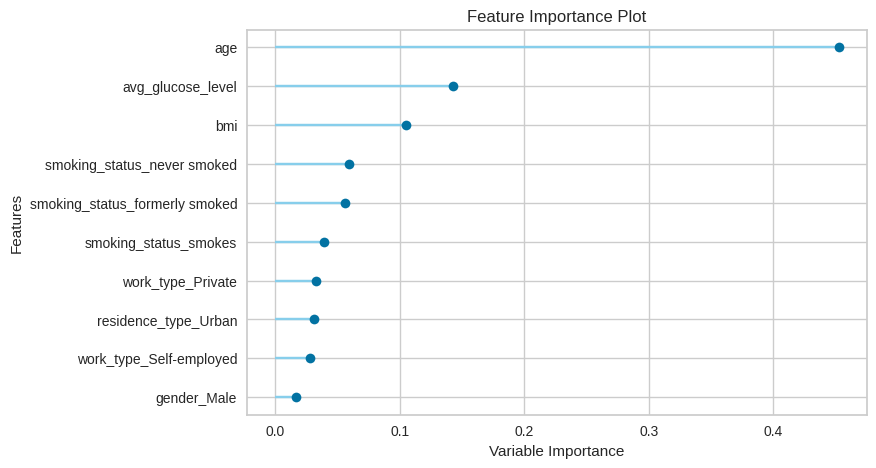

In [ ]:
plot_model(dt_model,"feature")

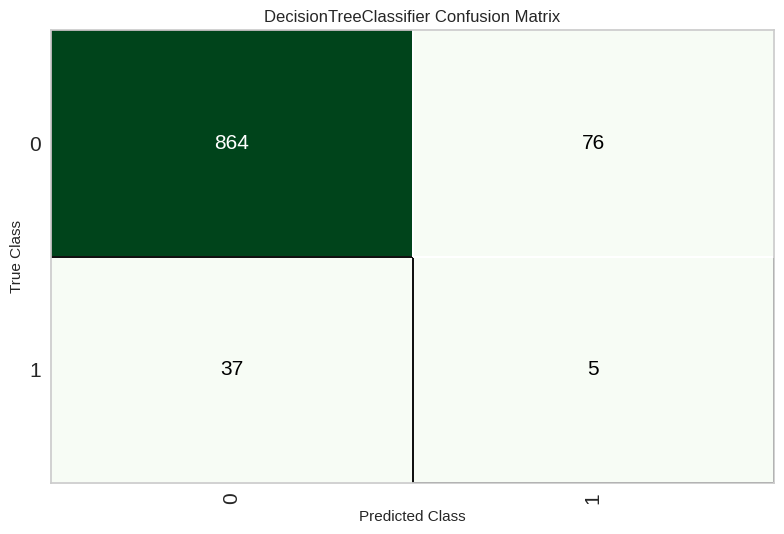

In [ ]:
plot_model(dt_model,"confusion_matrix")

In [ ]:
# Plot Decision Tree
plot_model(dt_model, plot="parameter")
print(dt_model)

,Parameters
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2
min_weight_fraction_leaf,0.0


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=24, splitter='best')


In [ ]:
# pull the other metrics for this decision tree model
metrics_df = pull()  # Pulls cross-validation metrics
print(metrics_df)  # This will be a pandas DataFrame

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8830  0.8830  0.8471  0.9126  0.8786  0.7660  0.7679
1       0.9262  0.9262  0.9747  0.8885  0.9296  0.8524  0.8564
2       0.9375  0.9375  0.9734  0.9082  0.9397  0.8750  0.8773
3       0.9422  0.9422  0.9628  0.9246  0.9433  0.8843  0.8851
4       0.9402  0.9402  0.9707  0.9148  0.9419  0.8803  0.8820
Mean    0.9258  0.9258  0.9457  0.9097  0.9266  0.8516  0.8537
Std     0.0221  0.0221  0.0495  0.0119  0.0245  0.0442  0.0440


In [ ]:
# Get the evaluation metrics of the test set in the decision tree model
predictions = predict_model(dt_model, data=test_data)
holdout_score = pull() # Pulls test set's evaluation metrics
type(holdout_score)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.8849,0.5191,0.1190,0.0617,0.0813,0.0265,0.0281


pandas.core.frame.DataFrame

In [ ]:
# create boosting ensemble models with just one line of code.
bagging_dt = ensemble_model(dt_model, method="Bagging")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8271,0.9228,0.7074,0.9301,0.8036,0.6543,0.6738
1,0.9588,0.9914,0.9787,0.9412,0.9596,0.9176,0.9183
2,0.9521,0.9895,0.9734,0.9337,0.9531,0.9043,0.9051
3,0.9601,0.9933,0.9814,0.9413,0.9609,0.9202,0.9210
4,0.9588,0.9858,0.9840,0.9367,0.9598,0.9176,0.9187
5,0.9654,0.9931,0.9707,0.9605,0.9656,0.9309,0.9309
6,0.9681,0.9954,0.9681,0.9681,0.9681,0.9362,0.9362
7,0.9694,0.9967,0.9787,0.9608,0.9697,0.9388,0.9390
8,0.9668,0.9944,0.9920,0.9443,0.9676,0.9335,0.9347


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
boosting = ensemble_model(dt_model, method= 'Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8285,0.8285,0.7261,0.9130,0.8089,0.6569,0.6711
1,0.9428,0.9428,0.9734,0.9173,0.9445,0.8856,0.8873
2,0.9375,0.9375,0.9734,0.9082,0.9397,0.8750,0.8773
3,0.9269,0.9269,0.9628,0.8983,0.9294,0.8537,0.8559
4,0.9428,0.9428,0.9654,0.9237,0.9441,0.8856,0.8865
5,0.9388,0.9388,0.9707,0.9125,0.9407,0.8777,0.8795
6,0.9548,0.9548,0.9628,0.9476,0.9551,0.9096,0.9097
7,0.9574,0.9574,0.9681,0.9479,0.9579,0.9149,0.9151
8,0.9402,0.9402,0.9707,0.9148,0.9419,0.8803,0.8820


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## AutoML

In [ ]:
from pycaret.classification import *

automl_experiment = setup(data=train_data_resampled,
                          target="stroke",
                          test_data=test_data,
                          fix_imbalance=False, # since we manually oversampling via SMOTE during train-test split
                          session_id=24, # seed config to ensure experiment's reproducility
                          preprocess=True, # since we've manually do the feature engineering
                          experiment_name = "automl_stroke_classification",
                          log_experiment=True,
                          log_plots=True,
                          log_profile=True,
                          log_data=True,
                          profile=True,
                          index=False)

# get a list of top 3 models
best_model = compare_models(sort="F1")

,Description,Value
0,Session id,24
1,Target,stroke
2,Target type,Binary
3,Original data shape,"(8502, 17)"
4,Transformed data shape,"(8502, 17)"
5,Transformed train set shape,"(7520, 17)"
6,Transformed test set shape,"(982, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


Loading profile... Please Wait!


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9581,0.9923,0.9668,0.9503,0.9566,0.9162,0.9191,0.1620
rf,Random Forest Classifier,0.9572,0.9926,0.9654,0.9494,0.9556,0.9144,0.9170,0.5360
et,Extra Trees Classifier,0.9537,0.9904,0.9633,0.9450,0.9518,0.9074,0.9109,0.3960
catboost,CatBoost Classifier,0.9532,0.9901,0.9657,0.9422,0.9515,0.9064,0.9101,4.8700
lightgbm,Light Gradient Boosting Machine,0.9533,0.9911,0.9620,0.9457,0.9513,0.9066,0.9103,49.3190
dt,Decision Tree Classifier,0.9322,0.9322,0.9444,0.9217,0.9314,0.8644,0.8669,0.0510
gbc,Gradient Boosting Classifier,0.9133,0.9712,0.9322,0.8985,0.9129,0.8266,0.8304,0.6250
knn,K Neighbors Classifier,0.8939,0.9567,0.9782,0.8373,0.9022,0.7878,0.7995,0.0910
ada,Ada Boost Classifier,0.8863,0.9578,0.8984,0.8774,0.8850,0.7726,0.7764,0.2340
ridge,Ridge Classifier,0.8771,0.9479,0.8854,0.8710,0.8760,0.7543,0.7572,0.0370


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
# get the pipeline
best_model_pipeline = get_config("pipeline")
best_model_pipeline

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['age', 'hypertension',
                                             'heart_disease', 'ever_married',
                                             'avg_glucose_level', 'bmi',
                                             'gender_Male', 'gender_Other',
                                             'smoking_status_formerly smoked',
                                             'smoking_status_never smoked',
                                             'smoking_status_smokes',
                                             'work_type_Never_worked',
                                             'work_type_Priv...
                ('categorical_imputer',
                 TransformerWrapper(exclude=None, include=[],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='most_frequent'))),
                ('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+')))],
         verbose=False)

In [ ]:
# hyperparameter tuning
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8178,0.9166,0.7660,0.8546,0.8079,0.6356,0.6391
1,0.9043,0.9905,0.9973,0.8408,0.9124,0.8085,0.8229
2,0.8790,0.9780,0.9973,0.8065,0.8918,0.7580,0.7801
3,0.9122,0.9876,0.9920,0.8555,0.9187,0.8245,0.8352
4,0.9122,0.9826,0.9973,0.8523,0.9191,0.8245,0.8367
5,0.9202,0.9856,0.9947,0.8657,0.9257,0.8404,0.8499
6,0.9202,0.9846,0.9947,0.8657,0.9257,0.8404,0.8499
7,0.9096,0.9882,0.9947,0.8500,0.9167,0.8191,0.8313
8,0.9136,0.9875,1.0000,0.8526,0.9204,0.8271,0.8398


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
# use test data instead?
predictions = predict_model(tuned_best_model)
predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9114,0.7504,0.1190,0.0909,0.1031,0.0574,0.0580


,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,gender_Male,gender_Other,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban,stroke,prediction_label,prediction_score
7520,57.0,0,0,1,189.570007,30.700001,1,0,0,1,0,0,1,0,0,1,0,0,0.9895
7521,49.0,0,0,1,78.339996,32.500000,1,0,0,0,0,0,1,0,0,0,0,0,0.9853
7522,25.0,0,0,1,65.599998,33.500000,0,0,0,1,0,0,1,0,0,1,0,0,0.9999
7523,37.0,0,0,1,73.500000,26.100000,0,0,1,0,0,0,1,0,0,0,0,0,0.9682
7524,14.0,0,0,0,161.279999,19.100000,1,0,0,0,0,1,0,0,0,0,0,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8497,25.0,0,0,0,78.589996,37.200001,0,0,0,1,0,0,1,0,0,1,0,0,0.9998
8498,15.0,0,0,0,77.550003,24.799999,1,0,0,0,0,0,1,0,0,1,0,0,0.9997
8499,37.0,0,0,1,203.809998,46.599998,0,0,0,1,0,0,1,0,0,1,0,0,1.0000
8500,43.0,0,0,1,110.419998,32.599998,0,0,0,0,1,0,1,0,0,1,0,0,0.9994


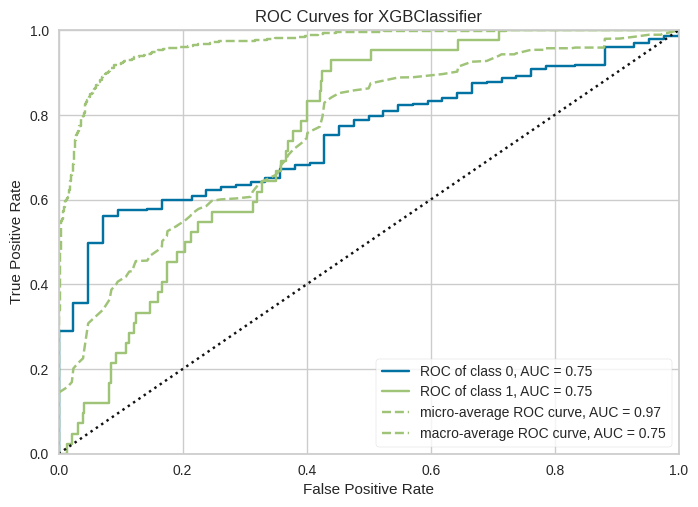

In [ ]:
plot_model(tuned_best_model, plot="auc")

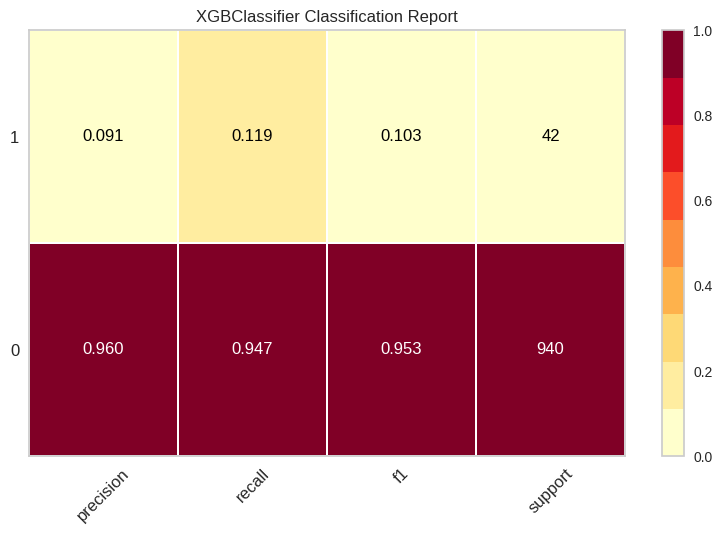

In [ ]:
plot_model(tuned_best_model, plot='class_report')

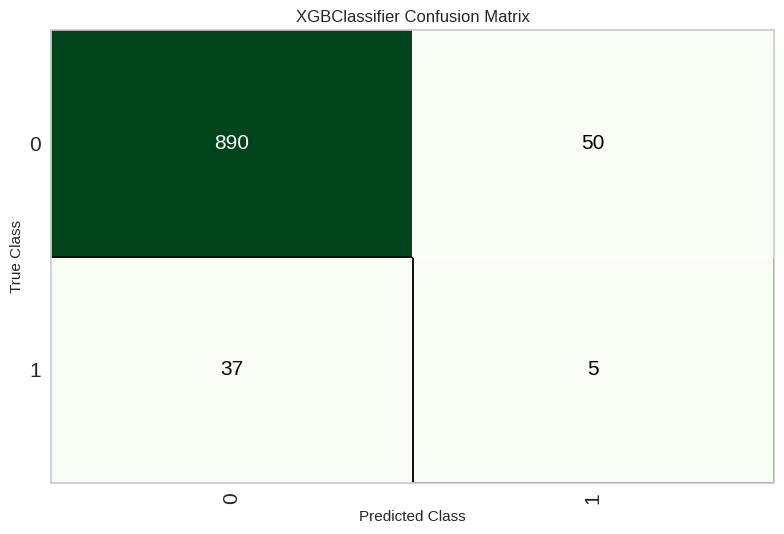

In [ ]:
plot_model(tuned_best_model, plot="confusion_matrix")

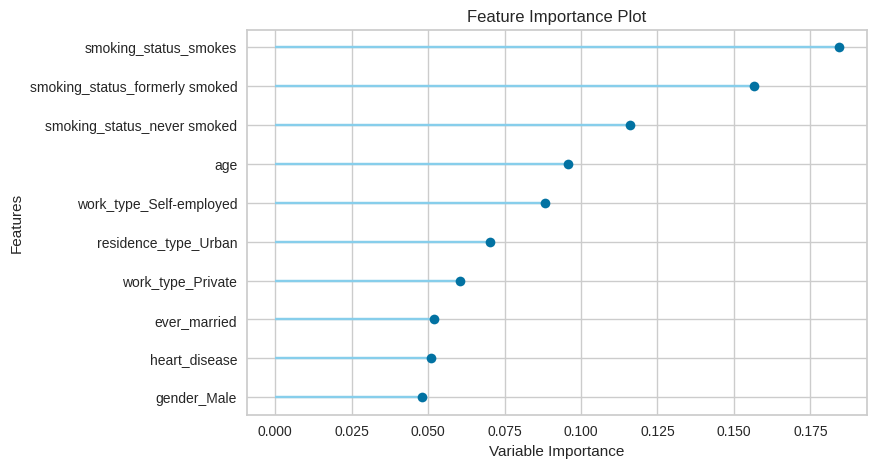

In [ ]:
plot_model(tuned_best_model, plot='feature')

In [ ]:
evaluate_model(tuned_best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

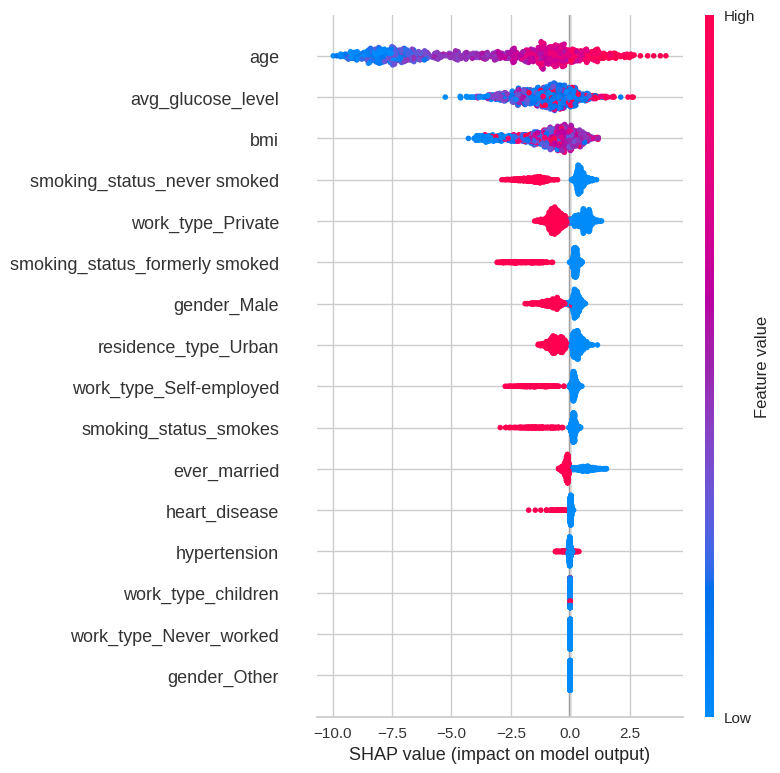

In [ ]:
interpret_model(tuned_best_model)

In [ ]:
predictions.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi', 'gender_Male', 'gender_Other',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'residence_type_Urban',
       'stroke', 'prediction_label', 'prediction_score'],
      dtype='object')

# Save model

In [ ]:
# save model
save_model(tuned_best_model, 'tuned_best_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['age', 'hypertension',
                                              'heart_disease', 'ever_married',
                                              'avg_glucose_level', 'bmi',
                                              'gender_Male', 'gender_Other',
                                              'smoking_status_formerly smoked',
                                              'smoking_status_never smoked',
                                              'smoking_status_smokes',
                                              'work_type_Never_worked',
                                              'work_type_Private',
                                              'work_...
                                importance_type=None,
                                interaction_constraints=None, learning_rate=None,
            

## Load model

In [ ]:
# load model
tuned_best_model = load_model(model_name='tuned_best_model')

Transformation Pipeline and Model Successfully Loaded


In [ ]:
tuned_best_model

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['age', 'hypertension',
                                             'heart_disease', 'ever_married',
                                             'avg_glucose_level', 'bmi',
                                             'gender_Male', 'gender_Other',
                                             'smoking_status_formerly smoked',
                                             'smoking_status_never smoked',
                                             'smoking_status_smokes',
                                             'work_type_Never_worked',
                                             'work_type_Priv...
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='binary:logistic', ...))],
         verbose=False)

## Part 2: Association Rule Mining

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

arm_data = train_data_resampled[train_data_resampled['stroke'] == 1].copy(deep=True)

# 1. Discretize continuous variables
arm_data["age_group"] = pd.cut(arm_data["age"], bins=[0, 60, 80, 100], labels=["<60", "60-80", "80+"])
arm_data["avg_glucose_high"] = (arm_data["avg_glucose_level"] > 140).astype(bool).map({False:0, True: 1})
arm_data["bmi_category"] = pd.cut(arm_data["bmi"], bins=[0, 18.5, 24.9, 29.9, 100],
                            labels=["underweight", "normal", "overweight", "obese"])

arm_data.drop(columns=["age", "avg_glucose_level", "bmi"], inplace=True)

# 3. Binarize categorical variables
arm_data = pd.get_dummies(arm_data, columns=["age_group", "bmi_category"], drop_first=True)

# 4. Generate Frequent Itemsets
frequent_itemsets = apriori(arm_data, min_support=0.2, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False)

,support,itemsets
4,1.0,(stroke)
0,0.812766,(ever_married)
10,0.812766,"(stroke, ever_married)"
6,0.614628,(age_group_60-80)
21,0.614628,"(stroke, age_group_60-80)"
12,0.499468,"(ever_married, age_group_60-80)"
30,0.499468,"(stroke, ever_married, age_group_60-80)"
23,0.469149,"(stroke, bmi_category_obese)"
8,0.469149,(bmi_category_obese)
32,0.391489,"(stroke, bmi_category_obese, ever_married)"


In [ ]:
# 5. Generate Association Rules
rules = association_rules(frequent_itemsets, metric="confidence",
                    min_threshold=0.7, num_itemsets=0)

# 6. Display Rules
pd.DataFrame(rules).sort_values(by="lift", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3,(avg_glucose_high),(ever_married),0.364628,0.812766,0.321543,0.881838,1.084984,1.0,0.025186,1.584555,0.123278,0.375699,0.368908,0.638727
19,(avg_glucose_high),"(stroke, ever_married)",0.364628,0.812766,0.321543,0.881838,1.084984,1.0,0.025186,1.584555,0.123278,0.375699,0.368908,0.638727
17,"(stroke, avg_glucose_high)",(ever_married),0.364628,0.812766,0.321543,0.881838,1.084984,1.0,0.025186,1.584555,0.123278,0.375699,0.368908,0.638727
0,(work_type_Private),(ever_married),0.371543,0.812766,0.323404,0.870437,1.070956,1.0,0.021427,1.445116,0.105425,0.375656,0.308014,0.634171
15,"(work_type_Private, stroke)",(ever_married),0.371543,0.812766,0.323404,0.870437,1.070956,1.0,0.021427,1.445116,0.105425,0.375656,0.308014,0.634171
16,(work_type_Private),"(stroke, ever_married)",0.371543,0.812766,0.323404,0.870437,1.070956,1.0,0.021427,1.445116,0.105425,0.375656,0.308014,0.634171
43,"(bmi_category_obese, avg_glucose_high)","(stroke, ever_married)",0.240691,0.812766,0.205851,0.855249,1.052269,1.0,0.010225,1.293487,0.065419,0.242862,0.226896,0.554260
41,"(stroke, bmi_category_obese, avg_glucose_high)",(ever_married),0.240691,0.812766,0.205851,0.855249,1.052269,1.0,0.010225,1.293487,0.065419,0.242862,0.226896,0.554260
30,"(avg_glucose_high, bmi_category_obese)",(ever_married),0.240691,0.812766,0.205851,0.855249,1.052269,1.0,0.010225,1.293487,0.065419,0.242862,0.226896,0.554260
40,"(avg_glucose_high, age_group_60-80)","(stroke, ever_married)",0.254255,0.812766,0.216489,0.851464,1.047613,1.0,0.009839,1.260533,0.060945,0.254534,0.206685,0.558913
